In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import  preprocessing # used for label encoding and imputing NaNs
from sklearn.metrics import classification_report


In [2]:
claimsdata = pd.read_csv("processedData.csv", parse_dates=['DateOfService', 'FirstBilledDate'])
claimsdata.head()

,Ticket Number,DateOfService,CarrierCode,Charges,Payments,InsurancePayment,PatientPayment,Writeoffs,InsuranceBal,PatientBal,...,CPT,DateOfEntry,PaymentPostDate,NPI,OrderingClinic,DeniedCode,FirstBilledDate,ProviderProfile,CaseCount,accepted
0,104452,2019-01-02,CFHP-E2,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,81507,1/7/2019,1/22/2019,1316428238,ALAMO WOMEN'S OBGYN,197,2019-01-08,NTINC,1,False
1,104453,2019-01-02,CFHP-E2,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,81507,1/7/2019,1/24/2019,1316428238,ALAMO WOMEN'S OBGYN,197,2019-01-08,NTINC,1,False
2,104454,2019-01-02,NCS,795,249.0,0.0,249.0,546.0,0.0,0.0,...,99999,1/7/2019,2/10/2019,1699760116,COMPREHENSIVE WOMEN'S HEALTHCARE,-,NaT,NTINC,1,True
3,104496,2019-01-02,AETLIF-E,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,81420,1/7/2019,1/28/2019,1609216597,PEACHTREE WOMEN'S CLINIC - NORTHSIDE,-,2019-01-08,NTINC,1,True
4,104497,2019-01-02,AETLIF-E,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,81420,1/7/2019,1/30/2019,1609216597,PEACHTREE WOMEN'S CLINIC - NORTHSIDE,-,2019-01-08,NTINC,1,True


In [3]:
claimsdata = claimsdata.loc[claimsdata['accepted'] == False]

In [4]:
claimsdata.shape

(13661, 22)

In [5]:
claimsdata.DeniedCode.unique() #Multiclass Clasification

array(['197', '96', '27', '242', '50', '109', '204', '16', '31', '24',
       '56', '15', '55', '279', '252', '170', 'A1', '256', '133', '198',
       '39', 'B11', '23', '8', '272', '182', '131', '18', '97', '167',
       '231', '222', '216', '234', '5', '200', '226', '129', '206', '208',
       '22', '4', '257', '177', '163', 'B22', '95', '33', '227', 'B5',
       'B7', '26', '243', '104', '140', '185', '62', '119', '49', '11',
       '102', '250', '9', 'P14', '183', '166', 'N52', '151', '10', '150',
       '284', '239', 'B15', '288', '181', 'B97', '148', '146', '32'],
      dtype=object)

In [6]:
pd.set_option('display.max_rows', 500)
pd.value_counts(claimsdata.DeniedCode) #imbalance

197    4091
55     1725
96     1344
252     974
16      943
204     566
97      415
27      329
109     260
A1      239
256     224
133     205
4       201
231     186
50      183
198     127
15      117
B11     113
23      112
P14     104
31       93
272      86
39       84
24       63
222      60
242      58
216      50
185      47
11       42
182      42
243      40
B22      38
8        33
279      32
49       32
22       29
177      27
B5       26
18       25
26       23
227      22
B7       19
56       18
95       18
146      17
119      16
10       16
166      14
226      12
B97      12
206      10
167      10
250       9
234       6
N52       6
62        6
200       6
131       5
170       5
181       4
9         4
5         4
102       3
150       3
151       3
129       3
284       3
B15       2
239       2
148       2
288       2
32        2
183       2
140       2
163       1
33        1
104       1
257       1
208       1
Name: DeniedCode, dtype: int64

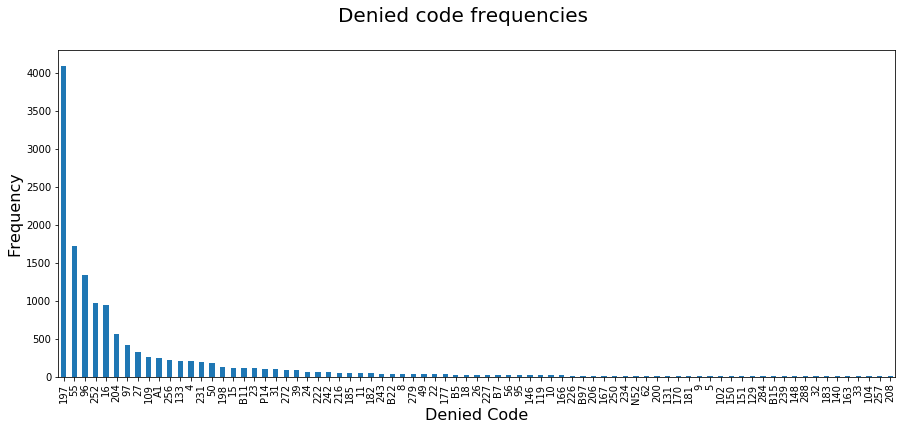

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6))
claimsdata['DeniedCode'].value_counts().plot.bar(ylim=0)
fig.suptitle('Denied code frequencies', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Denied Code', fontsize=16)
plt.show()
# fig.savefig("deniedcodes-all.png")

In [8]:
lbl1 = preprocessing.LabelEncoder()
lbl1.fit(list(claimsdata['DeniedCode'].values)) 
claimsdata['DeniedCode_preprocessed'] = lbl1.transform(list(claimsdata['DeniedCode'].values))
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y
helpful_normalized = normalize(claimsdata['DeniedCode_preprocessed'])
helpful_normalized.describe()



count    13661.000000
mean         0.524379
std          0.257115
min          0.000000
25%          0.333333
50%          0.474359
75%          0.794872
max          1.000000
Name: DeniedCode_preprocessed, dtype: float64

In [9]:
helpful_normalized.head()

0    0.333333
1    0.333333
5    0.871795
6    0.871795
9    0.871795
Name: DeniedCode_preprocessed, dtype: float64

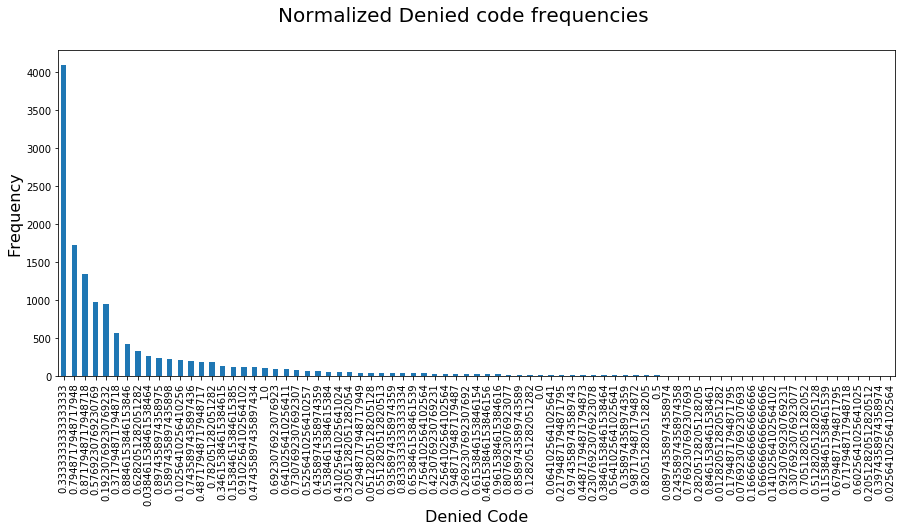

In [10]:
fig = plt.figure(figsize=(15,6))
helpful_normalized.value_counts().plot.bar(ylim=0)
fig.suptitle('Normalized Denied code frequencies', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Denied Code', fontsize=16)
plt.show()
fig.savefig("normalized-deniedcodes-all.png")

In [11]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y
helpful_sigmoid = sigmoid(claimsdata['DeniedCode_preprocessed'])
helpful_sigmoid.describe()

count    13661.000000
mean         0.998375
std          0.018734
min          0.500000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: DeniedCode_preprocessed, dtype: float64

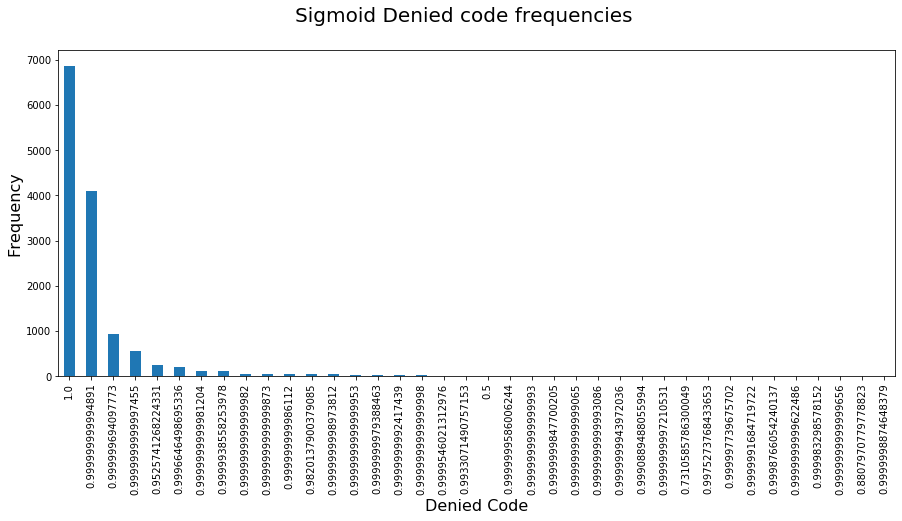

In [12]:
fig = plt.figure(figsize=(15,6))
helpful_sigmoid.value_counts().plot.bar(ylim=0)
fig.suptitle('Sigmoid Denied code frequencies', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Denied Code', fontsize=16)
plt.show()
fig.savefig("sigmoid-deniedcodes-all.png")

In [13]:
helpful_log = np.log(claimsdata['DeniedCode_preprocessed'] + 1)
helpful_log.describe()

count    13661.000000
mean         3.583780
std          0.616561
min          0.000000
25%          3.295837
50%          3.637586
75%          4.143135
max          4.369448
Name: DeniedCode_preprocessed, dtype: float64

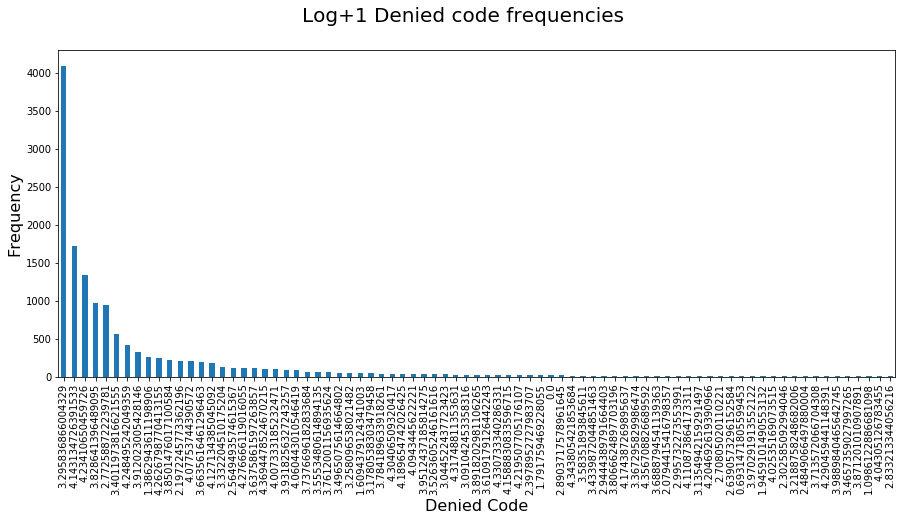

In [14]:
fig = plt.figure(figsize=(15,6))
helpful_log.value_counts().plot.bar(ylim=0)
fig.suptitle('Log+1 Denied code frequencies', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Denied Code', fontsize=16)
plt.show()
fig.savefig("log1-deniedcodes-all.png")

In [15]:
# Log Function + 1 Normalized
helpful_log_normalized = normalize(helpful_log)
helpful_log_normalized.describe()

count    13661.000000
mean         0.820191
std          0.141107
min          0.000000
25%          0.754291
50%          0.832505
75%          0.948206
max          1.000000
Name: DeniedCode_preprocessed, dtype: float64

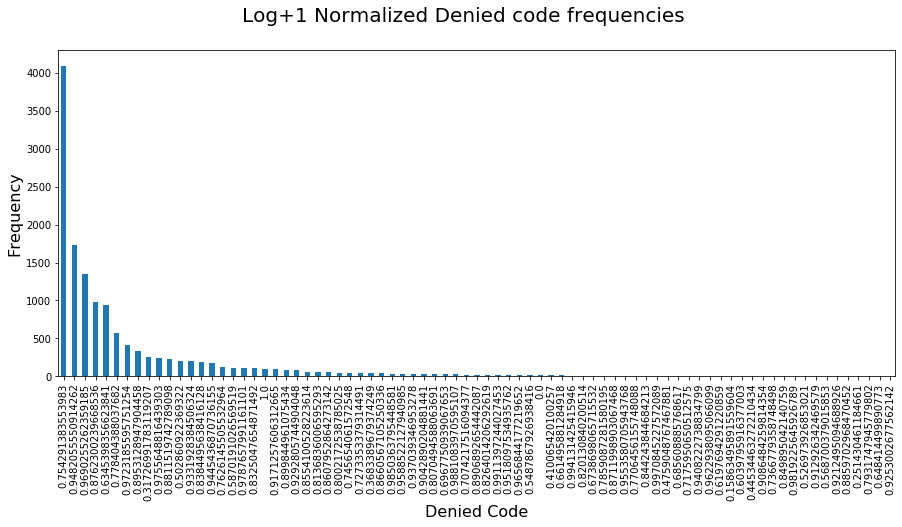

In [16]:
fig = plt.figure(figsize=(15,6))
helpful_log_normalized.value_counts().plot.bar(ylim=0)
fig.suptitle('Log+1 Normalized Denied code frequencies', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Denied Code', fontsize=16)
plt.show()
fig.savefig("log1-normalized-deniedcodes-all.png")

In [17]:
# Anything that occurs less than this will be replaced
thresholds = [20,30,40,50,70,100]

indexarr = [None,None,None,None,None,None]
value_counts = claimsdata['DeniedCode'].value_counts() # DenialCode column 
for i in range (6):
    to_replace = value_counts[value_counts <= thresholds[i]].index
    indexarr[i]=to_replace
    claimsdata['DeniedCode'].replace(to_replace, 'other-category-'+str(i+1), inplace=True)
    value_counts = claimsdata['DeniedCode'].value_counts() # DenialCode column 
print(indexarr)

[Index(['B7', '56', '95', '146', '119', '10', '166', '226', 'B97', '206', '167',
       '250', '234', 'N52', '62', '200', '131', '170', '181', '9', '5', '102',
       '150', '151', '129', '284', 'B15', '239', '148', '288', '32', '183',
       '140', '163', '33', '104', '257', '208'],
      dtype='object'), Index(['22', '177', 'B5', '18', '26', '227'], dtype='object'), Index(['243', 'B22', '8', '279', '49'], dtype='object'), Index(['216', '185', '182', '11'], dtype='object'), Index(['24', '222', '242'], dtype='object'), Index(['31', '272', '39'], dtype='object')]


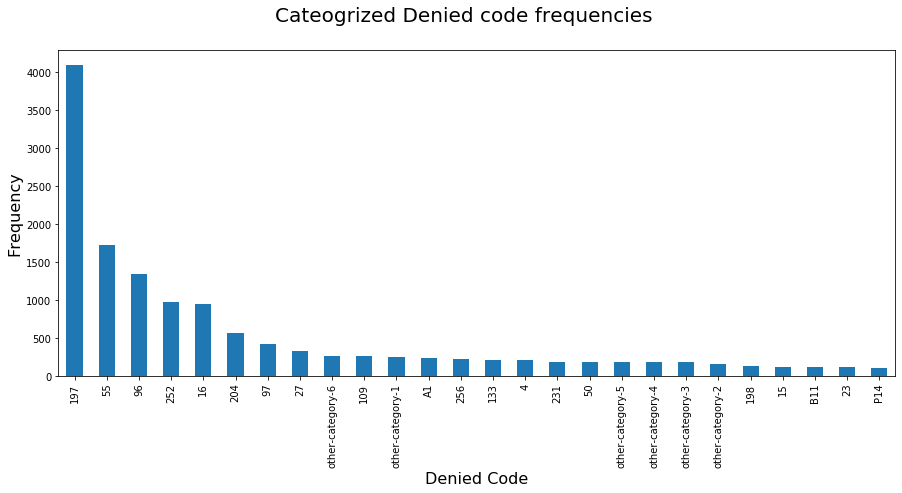

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6))
claimsdata['DeniedCode'].value_counts().plot.bar(ylim=0)
fig.suptitle('Cateogrized Denied code frequencies', fontsize=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Denied Code', fontsize=16)
plt.show()
fig.savefig("categorized-deniedcodes-all.png")
#imbalanced

Goal: 
    high prediction accuracy: majority class
    reasonable accuracy: minority classes

In [19]:
claimsdata['DeniedCode'].value_counts()

197                 4091
55                  1725
96                  1344
252                  974
16                   943
204                  566
97                   415
27                   329
other-category-6     263
109                  260
other-category-1     251
A1                   239
256                  224
133                  205
4                    201
231                  186
50                   183
other-category-5     181
other-category-4     181
other-category-3     175
other-category-2     152
198                  127
15                   117
B11                  113
23                   112
P14                  104
Name: DeniedCode, dtype: int64

In [20]:
#derived variable timedelta
claimsdata = claimsdata.dropna(subset=['FirstBilledDate']) #dropping down those records there is only few
claimsdata['timedelta'] = (claimsdata['FirstBilledDate'] - claimsdata['DateOfService']).dt.days.astype(int)
claimsdata[['DateOfService', 'FirstBilledDate', 'timedelta']].head()

,DateOfService,FirstBilledDate,timedelta
0,2019-01-02,2019-01-08,6
1,2019-01-02,2019-01-08,6
5,2019-01-02,2019-01-08,6
6,2019-01-02,2019-01-08,6
9,2019-01-02,2019-01-08,6


In [21]:
#Encoding categorical features
#naive approach and assign a numeric value to each categorical feature
#LabelEncoder()

claimsdata['NPI'] = claimsdata['NPI'].astype('object')
for c in claimsdata.columns:
    if (claimsdata[c].dtype == 'object' and c!='DeniedCode'):
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(claimsdata[c].values)) 
        claimsdata[c] = lbl.transform(list(claimsdata[c].values))

In [22]:
claimsdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13661 entries, 0 to 22695
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Ticket Number            13661 non-null  int64         
 1   DateOfService            13661 non-null  datetime64[ns]
 2   CarrierCode              13661 non-null  int64         
 3   Charges                  13661 non-null  int64         
 4   Payments                 13661 non-null  float64       
 5   InsurancePayment         13661 non-null  float64       
 6   PatientPayment           13661 non-null  float64       
 7   Writeoffs                13661 non-null  float64       
 8   InsuranceBal             13661 non-null  float64       
 9   PatientBal               13661 non-null  float64       
 10  AllowedAmount            13661 non-null  float64       
 11  FinancialClass           13661 non-null  int64         
 12  CPT                      13661 n

In [23]:
#Remove unwanted columns
X_claims = claimsdata.drop(['Ticket Number', 'CaseCount', 'DateOfService', 'FirstBilledDate', 'DeniedCode', 'PaymentPostDate', 'DateOfEntry', 'accepted', 'DeniedCode_preprocessed'], axis=1)
y_claims = claimsdata['DeniedCode']
#split into train data and test data
X_train, X_test, y_train, y_test = train_test_split(X_claims, y_claims, test_size = 0.20)

In [24]:
X_claims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13661 entries, 0 to 22695
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CarrierCode       13661 non-null  int64  
 1   Charges           13661 non-null  int64  
 2   Payments          13661 non-null  float64
 3   InsurancePayment  13661 non-null  float64
 4   PatientPayment    13661 non-null  float64
 5   Writeoffs         13661 non-null  float64
 6   InsuranceBal      13661 non-null  float64
 7   PatientBal        13661 non-null  float64
 8   AllowedAmount     13661 non-null  float64
 9   FinancialClass    13661 non-null  int64  
 10  CPT               13661 non-null  int64  
 11  NPI               13661 non-null  int64  
 12  OrderingClinic    13661 non-null  int64  
 13  ProviderProfile   13661 non-null  int64  
 14  timedelta         13661 non-null  int32  
dtypes: float64(7), int32(1), int64(7)
memory usage: 1.6 MB


In [25]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred_test = gnb.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred_test)

0.08525429930479327

In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
logreg.score(X_test,y_test)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

C:\Users\Pubudu.C\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.33735821441639224

In [27]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')
clf.fit(X_train,y_train)
y_pred3 = clf.predict(X_test)
accuracy_score(y_test,y_pred3)

0.6143432125869008

In [28]:
def run_decisionTree(X_train, X_test, y_train, y_test):
    model = tree.DecisionTreeClassifier()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("Score: ", model.score(X_test, y_test))
    print ("Classification report: ", classification_report(y_test, y_pred))
    return model.score(X_test, y_test)

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn import tree
from sklearn.metrics import accuracy_score
number_of_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
accuracy_decision_tree = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]

for index in range(1, 16):
        decisionTreeRFELoop = RFE(tree.DecisionTreeClassifier(max_depth = 5),n_features_to_select = index)
        decisionTreeRFELoop.fit(X_train,y_train)
        X_train_DecisionTree_RFELoop = decisionTreeRFELoop.transform(X_train)
        X_test_DecisionTree_RFELoop = decisionTreeRFELoop.transform(X_test)
        print("selected features:", index)
        accuracy_decision_tree[index-1] = run_decisionTree(X_train_DecisionTree_RFELoop, X_test_DecisionTree_RFELoop, y_train, y_test)
        print()

selected features: 1
Score:  0.6611781924624954
Classification report:                    precision    recall  f1-score   support

             109       0.55      0.82      0.66        51
             133       0.57      0.89      0.70        44
              15       0.78      0.82      0.80        22
              16       0.81      0.53      0.64       172
             197       0.76      0.83      0.80       810
             198       0.25      0.06      0.10        17
             204       0.72      0.68      0.70       111
              23       0.00      0.00      0.00        34
             231       0.00      0.00      0.00        40
             252       0.71      0.86      0.78       218
             256       0.79      0.89      0.84        46
              27       0.50      0.01      0.03        70
               4       0.94      0.38      0.55        39
              50       0.00      0.00      0.00        36
              55       0.61      0.92      0.73       358

C:\Users\Pubudu.C\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


selected features: 2
Score:  0.76143432125869
Classification report:                    precision    recall  f1-score   support

             109       0.72      0.84      0.77        51
             133       0.56      0.70      0.63        44
              15       0.68      0.95      0.79        22
              16       0.63      0.67      0.65       172
             197       0.83      0.86      0.85       810
             198       0.50      0.24      0.32        17
             204       0.85      0.84      0.85       111
              23       0.35      0.21      0.26        34
             231       0.77      0.93      0.84        40
             252       0.71      0.86      0.78       218
             256       0.88      1.00      0.94        46
              27       0.27      0.14      0.19        70
               4       0.94      0.41      0.57        39
              50       0.58      0.78      0.67        36
              55       0.84      0.92      0.88       358
 

selected features: 7
Score:  0.8283937065495792
Classification report:                    precision    recall  f1-score   support

             109       0.91      0.98      0.94        51
             133       0.58      0.43      0.49        44
              15       0.96      1.00      0.98        22
              16       0.73      0.77      0.75       172
             197       0.86      0.91      0.88       810
             198       0.62      0.59      0.61        17
             204       0.84      0.83      0.84       111
              23       0.79      0.56      0.66        34
             231       0.87      0.97      0.92        40
             252       0.85      0.88      0.86       218
             256       0.96      1.00      0.98        46
              27       0.75      0.63      0.68        70
               4       0.74      0.44      0.55        39
              50       0.81      0.81      0.81        36
              55       0.90      0.94      0.92       358

selected features: 12
Score:  0.8946212952799122
Classification report:                    precision    recall  f1-score   support

             109       0.98      0.96      0.97        51
             133       0.50      0.55      0.52        44
              15       0.88      1.00      0.94        22
              16       0.90      0.91      0.90       172
             197       0.93      0.94      0.93       810
             198       0.59      0.76      0.67        17
             204       0.86      0.82      0.84       111
              23       0.89      0.71      0.79        34
             231       0.92      0.82      0.87        40
             252       0.97      0.93      0.95       218
             256       0.94      1.00      0.97        46
              27       0.97      0.81      0.88        70
               4       0.84      0.92      0.88        39
              50       0.87      0.94      0.91        36
              55       0.93      0.94      0.93       35

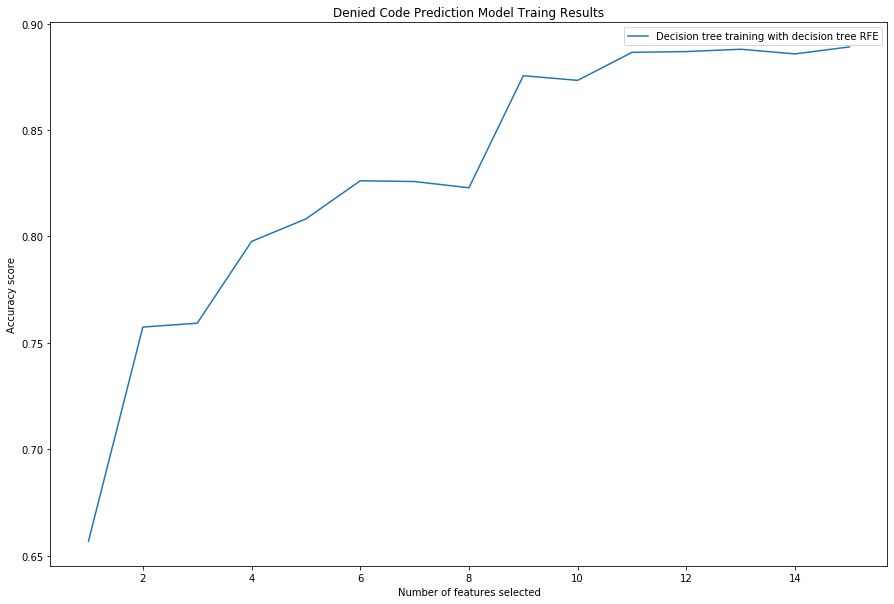

In [118]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))

# line 1 points
x1 = number_of_features
y1 = accuracy_decision_tree
# plotting the line 1 points 
plt.plot(x1, y1, label = "Decision tree training with decision tree RFE")

plt.xlabel('Number of features selected')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy score')
# Set a title of the current axes.
plt.title('Denied Code Prediction Model Traing Results')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
fig.savefig("decision-tree-denial-pred.png",dpi=100)


In [95]:
#given data set is highly imbalanced

In [96]:
#taking results categorizing many Deniedcodes together may not add much value to the business

In [97]:
#try with different models such as keras deep learning frameworks in future work

In [98]:
# analysis with sigmoid data